In [1]:
import os
import cv2
import glob
import numpy as np

from PIL import Image

In [2]:
dataset_base_path = 'dataset/rps'

rock_path = os.path.join(dataset_base_path, 'rock', '*.png')
paper_path = os.path.join(dataset_base_path, 'paper', '*.png')
scissor_path = os.path.join(dataset_base_path, 'scissors', '*.png')

rock_enum = glob.glob(rock_path)
paper_enum = glob.glob(paper_path)
scissor_enum = glob.glob(scissor_path)

In [3]:
all_images_path = []
all_images_path.extend(rock_enum)
all_images_path.extend(paper_enum)
all_images_path.extend(scissor_enum)

In [4]:
loaded_images = []
label_images = []

def normalization(img):
    return img/255

for idx, image_path in enumerate(all_images_path):
    # Obtain the label
    image_path = image_path.replace("\\", '/')
    
    # Load in pil and convert to CV BGR format
    img = Image.open(image_path).convert('RGB')
    cv_converted_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # resize
    cv_converted_img = cv2.resize(cv_converted_img, (128, 128))

    # Perform a normalization
    img_norm = normalization(cv_converted_img)

    # Append
    loaded_images.append(img_norm)
    label_images.append(image_path.split("/")[2])


In [5]:
# Labels 0 = non-adversarial example
# Labels 1 = black-box attack
# Labels 2 = white-box attack

In [6]:
# Augment the data

In [7]:
from sklearn.preprocessing import LabelEncoder

# Transform the label from string to encoded form
label_encoder = LabelEncoder().fit(label_images)
encoded_label_images = label_encoder.transform(label_images)

In [8]:
labels = ['scissors', 'rock', 'paper']
actual_label = label_encoder.transform(labels)

print(labels)
print(actual_label)

['scissors', 'rock', 'paper']
[2 1 0]


In [9]:
print(label_images[1800], encoded_label_images[1800])

scissors 2


In [10]:
print(len(loaded_images), len(label_images))

2188 2188


In [11]:
from sklearn.model_selection import StratifiedKFold as skf

K = 4

# Convert to numpy before cross-validation
encoded_label_images = np.array(encoded_label_images)
label_images = np.array(label_images)
loaded_images = np.array(loaded_images)

skf_conf = skf(n_splits=K)
for i, (train_index, test_index) in enumerate(skf_conf.split(loaded_images, encoded_label_images)):
    x_train, y_train, label_images_train = loaded_images[train_index], encoded_label_images[train_index], label_images[train_index]
    x_test, y_test, label_images_test = loaded_images[test_index], encoded_label_images[test_index], label_images[test_index]

In [12]:
from collections import Counter

# Calculate each class image distribution in each set
def calculate_distribution(y):
    counter = Counter(y_train)
    for k, v in counter.items():
        per= v / len(y_train) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print("Train distribution : ")
calculate_distribution(y_train)
print("Test distribution : ")
calculate_distribution(y_test)

Train distribution : 
Class=1, n=545 (33.211%)
Class=0, n=534 (32.541%)
Class=2, n=562 (34.247%)
Test distribution : 
Class=1, n=545 (33.211%)
Class=0, n=534 (32.541%)
Class=2, n=562 (34.247%)


In [13]:
# Save the original x_train and test
#np.savez('adversarial_example/raw/train_set.npz', x=x_train, y=y_train)
#np.savez('adversarial_example/raw/test_set.npz', x=x_test, y=y_test)

1 2 0
rock scissors paper


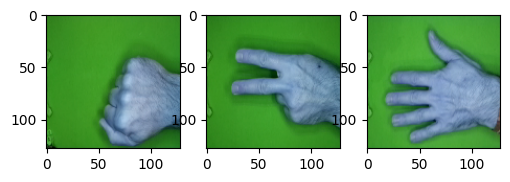

In [14]:
import matplotlib.pyplot as plt

# Get every image from each class
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(4, 5, 1)
plt.imshow(x_train[0])

fig.add_subplot(4, 5, 2)
plt.imshow(x_train[1500])

fig.add_subplot(4, 5, 3)
plt.imshow(x_train[1000])

# Plotting image sample

print(y_train[0], y_train[1500], y_train[1000])
print(label_images_train[0], label_images_train[1500], label_images_train[1000])

In [15]:
# Augmentation for training

def flip(img, preference='horizontal'):
    if preference == 'horizontal':
        return cv2.flip(img, 1)
    if preference == 'vertical':
        return cv2.flip(img, 0)
    
def brightness(img, brightness_value=0.05):
    if brightness_value != 0:
        if brightness_value > 0:
            shadow = brightness_value
            highlight = 1
        else:
            shadow = 0
            highlight = 1 + brightness_value
        alpha_b = (highlight - shadow)/1
        gamma_b = shadow
        buf = cv2.addWeighted(img, alpha_b, img, 0, gamma_b)
    else:
        buf = img.copy()

    return buf

def gaussian_blur(img, kernel_size=(3, 3), intensity=0.1):
    return cv2.GaussianBlur(img, kernel_size, intensity)


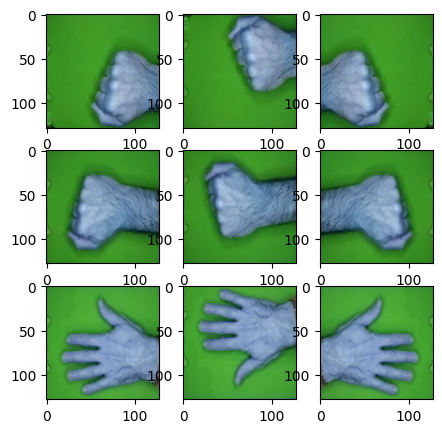

In [16]:
# Sample of flipping
# Get every image from each class
fig = plt.figure(figsize=(5, 5))
fig.add_subplot(3, 3, 1)
plt.imshow(x_train[0])
fig.add_subplot(3, 3, 2)
plt.imshow(flip(x_train[0], preference='vertical'))
fig.add_subplot(3, 3, 3)
plt.imshow(flip(x_train[0], preference='horizontal'))

fig.add_subplot(3, 3, 4)
plt.imshow(x_train[500])
fig.add_subplot(3, 3, 5)
plt.imshow(flip(x_train[500], preference='vertical'))
fig.add_subplot(3, 3, 6)
plt.imshow(flip(x_train[500], preference='horizontal'))

fig.add_subplot(3, 3, 7)
plt.imshow(x_train[1000])
fig.add_subplot(3, 3, 8)
plt.imshow(flip(x_train[1000], preference='vertical'))
fig.add_subplot(3, 3, 9)
plt.imshow(flip(x_train[1000], preference='horizontal'))

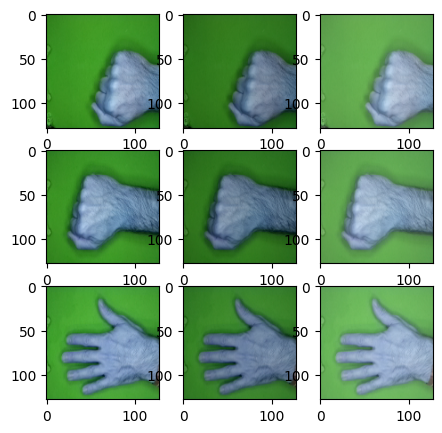

In [17]:
# Sample of increase brightness
# Get every image from each class
fig = plt.figure(figsize=(5, 5))
fig.add_subplot(3, 3, 1)
plt.imshow(x_train[0])
fig.add_subplot(3, 3, 2)
plt.imshow(brightness(x_train[0], brightness_value=-0.2))
fig.add_subplot(3, 3, 3)
plt.imshow(brightness(x_train[0], brightness_value=0.2))

fig.add_subplot(3, 3, 4)
plt.imshow(x_train[500])
fig.add_subplot(3, 3, 5)
plt.imshow(brightness(x_train[500], brightness_value=-0.2))
fig.add_subplot(3, 3, 6)
plt.imshow(brightness(x_train[500], brightness_value=0.2))

fig.add_subplot(3, 3, 7)
plt.imshow(x_train[1000])
fig.add_subplot(3, 3, 8)
plt.imshow(brightness(x_train[1000], brightness_value=-0.2))
fig.add_subplot(3, 3, 9)
plt.imshow(brightness(x_train[1000], brightness_value=0.2))

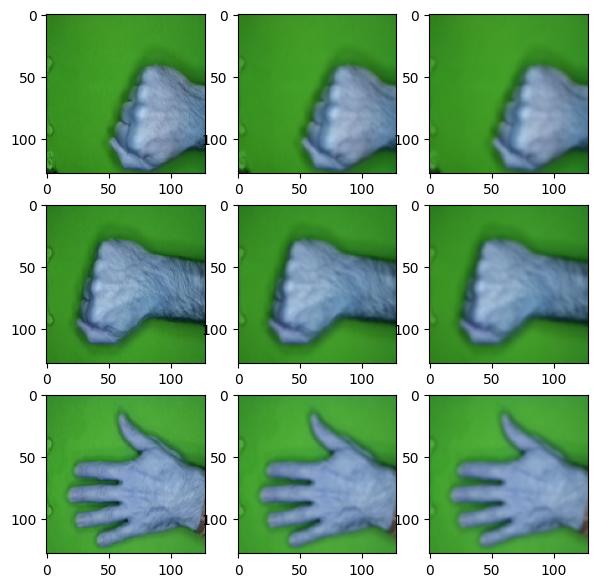

In [18]:
# Sample of gaussian blur
# Get every image from each class
fig = plt.figure(figsize=(7, 7))
fig.add_subplot(3, 3, 1)
plt.imshow(x_train[0])
fig.add_subplot(3, 3, 2)
plt.imshow(gaussian_blur(x_train[0], kernel_size=(3, 3), intensity=0))
fig.add_subplot(3, 3, 3)
plt.imshow(gaussian_blur(x_train[0], kernel_size=(5, 5), intensity=0))

fig.add_subplot(3, 3, 4)
plt.imshow(x_train[500])
fig.add_subplot(3, 3, 5)
plt.imshow(gaussian_blur(x_train[500], kernel_size=(3, 3), intensity=0))
fig.add_subplot(3, 3, 6)
plt.imshow(gaussian_blur(x_train[500], kernel_size=(5, 5), intensity=0))

fig.add_subplot(3, 3, 7)
plt.imshow(x_train[1000])
fig.add_subplot(3, 3, 8)
plt.imshow(gaussian_blur(x_train[1000], kernel_size=(3, 3), intensity=0))
fig.add_subplot(3, 3, 9)
plt.imshow(gaussian_blur(x_train[1000], kernel_size=(5, 5), intensity=0))

In [19]:
augmented_x_train = []
augmented_y_train = []

# Apply augmentation for each data
for idx, x in enumerate(x_train):
    # Brightness changes
    augmented_x_train.append(cv2.resize(brightness(x, brightness_value=-0.2), (128, 128)))
    augmented_y_train.append(y_train[idx])
    augmented_x_train.append(cv2.resize(brightness(x, brightness_value=0.2), (128, 128)))
    augmented_y_train.append(y_train[idx])

    # Flip changes
    augmented_x_train.append(cv2.resize(flip(x, preference='vertical'), (128, 128)))
    augmented_y_train.append(y_train[idx])
    augmented_x_train.append(cv2.resize(flip(x, preference='horizontal'), (128, 128)))
    augmented_y_train.append(y_train[idx])

    # Gaussian Blur
    augmented_x_train.append(cv2.resize(gaussian_blur(x, kernel_size=(3, 3), intensity=0), (128, 128)))
    augmented_y_train.append(y_train[idx])
    augmented_x_train.append(cv2.resize(gaussian_blur(x, kernel_size=(5, 5), intensity=0), (128, 128)))
    augmented_y_train.append(y_train[idx])



In [20]:
x_train_list = x_train.tolist()
y_train_list = y_train.tolist()

x_train_list.extend(augmented_x_train)
y_train_list.extend(augmented_y_train)

x_train = np.array(x_train_list)
y_train = np.array(y_train_list)

In [21]:
import tensorflow as tf

# Encode every labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [22]:
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [32]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.summary()

    return model

model = create_model(input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 32)         

In [33]:
LEARNING_RATE = 0.001
OPTIMIZER = 'ADAM'
EPOCHS = 10
BATCH_SIZE = 128

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
with tf.device('/gpu:0'):
    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_test, y_test),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1
    )

Epoch 1/10
90/90 [==============================] - 3s 29ms/step - loss: 0.4648 - accuracy: 0.8063 - val_loss: 0.1117 - val_accuracy: 0.9543
Epoch 2/10
90/90 [==============================] - 2s 25ms/step - loss: 0.1147 - accuracy: 0.9617 - val_loss: 0.0904 - val_accuracy: 0.9671
Epoch 3/10
90/90 [==============================] - 2s 26ms/step - loss: 0.0711 - accuracy: 0.9798 - val_loss: 0.0445 - val_accuracy: 0.9799
Epoch 4/10
90/90 [==============================] - 2s 27ms/step - loss: 0.0418 - accuracy: 0.9877 - val_loss: 0.0294 - val_accuracy: 0.9890
Epoch 5/10
90/90 [==============================] - 2s 27ms/step - loss: 0.0313 - accuracy: 0.9918 - val_loss: 0.0430 - val_accuracy: 0.9854
Epoch 6/10
90/90 [==============================] - 2s 27ms/step - loss: 0.0294 - accuracy: 0.9906 - val_loss: 0.0356 - val_accuracy: 0.9854
Epoch 7/10
90/90 [==============================] - 2s 26ms/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 0.0540 - val_accuracy: 0.9799
Epoch 8/10
90

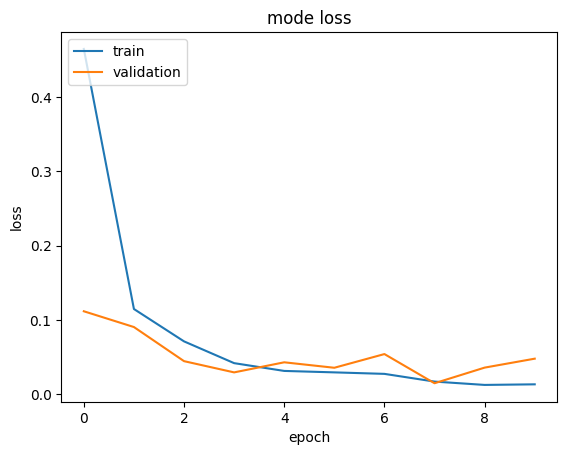

In [36]:
import matplotlib.pyplot as plt

# Save Train result
fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mode loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

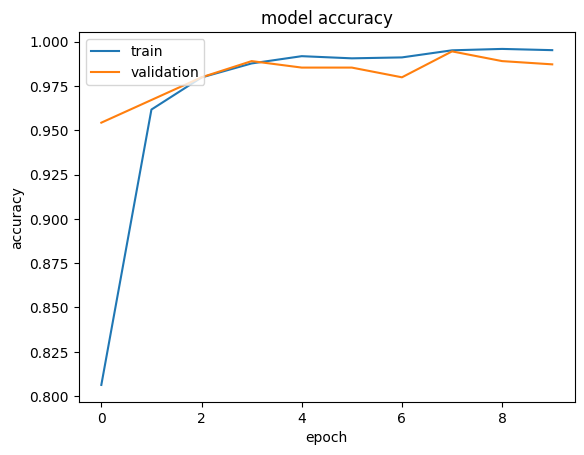

In [37]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [38]:
training_conf = {
    'labels_string':labels,
    'labels_encoded':actual_label.tolist(),
    'optimizer':OPTIMIZER,
    'learning_rate':LEARNING_RATE,
    'epochs':EPOCHS,
    'batch_size':BATCH_SIZE,
    'model_summary':str(model.summary())
}

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 32)         

In [39]:
import json

save_name = 'trained_cnn_v1.0_non_adversary_example'
def save_model(model, model_accuracy, model_loss, training_conf, save_folder):
    # Creating the folder if doesnt exist and vice versa
    save_folder_path = os.path.join('weight', save_folder)
    if not os.path.exists(save_folder_path):
        os.makedirs(save_folder_path)

    model_loss.savefig(os.path.join(save_folder_path, 'training_loss.jpg'))
    model_accuracy.savefig(os.path.join(save_folder_path, 'training_accuracy.jpg'))
    model.save_weights(os.path.join(save_folder_path, 'weight.h5'))
    model.save(os.path.join(save_folder_path, 'conf_weight.h5'))

    with open(os.path.join(save_folder_path, 'training_conf.json'), 'w') as f:
        json.dump(training_conf, f, indent=4)

In [40]:
save_model(model=model, model_accuracy=fig, model_loss=fig1, training_conf=training_conf, save_folder=save_name)